In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.83MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
def create_iid_clients(dataset, num_clients=100):
    data_per_client = len(dataset) // num_clients
    all_indices = list(range(len(dataset)))
    random.shuffle(all_indices)

    client_dict = {}
    for i in range(num_clients):
        client_dict[i] = all_indices[i * data_per_client : (i + 1) * data_per_client]
    return client_dict

iid_clients = create_iid_clients(mnist_train, num_clients=100)


In [5]:
def create_noniid_clients(dataset, num_clients=100, num_shards=200, shard_size=300):
    # Sort by label
    data_indices = np.argsort(dataset.targets.numpy())
    shards = [data_indices[i * shard_size : (i + 1) * shard_size] for i in range(num_shards)]
    random.shuffle(shards)

    client_dict = defaultdict(list)
    for i in range(num_clients):
        client_shards = shards[2*i : 2*i + 2]
        client_indices = np.concatenate(client_shards)
        client_dict[i] = client_indices
    return client_dict

noniid_clients = create_noniid_clients(mnist_train)


In [6]:
class MNIST_2NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [7]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # -> [batch, 32, 12, 12]
        x = self.pool(F.relu(self.conv2(x)))   # -> [batch, 64, 4, 4]
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [8]:
def get_client_loader(dataset, client_indices, batch_size=32):
    return DataLoader(Subset(dataset, client_indices), batch_size=batch_size, shuffle=True)


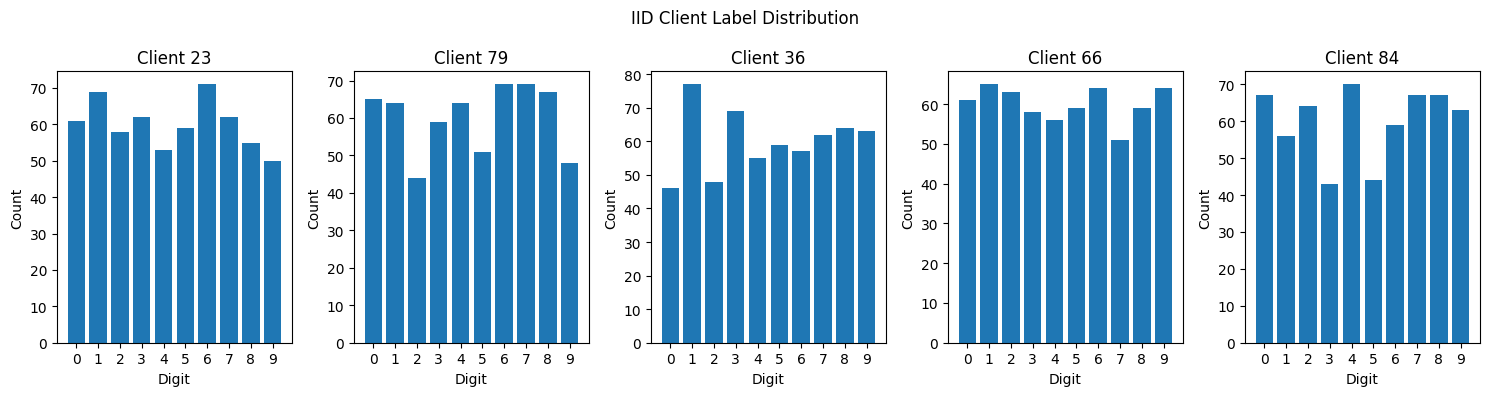

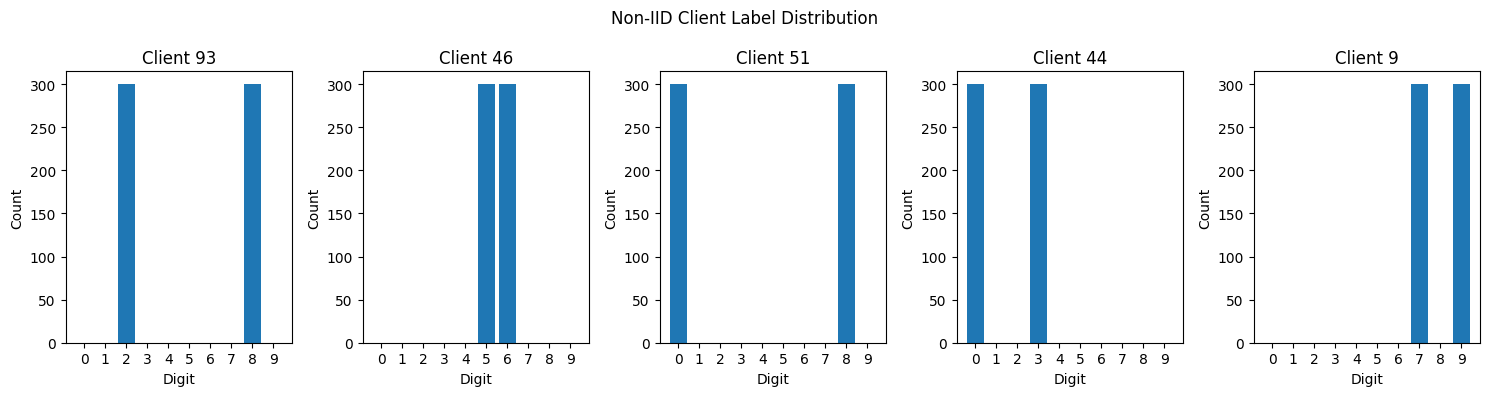

In [9]:
import matplotlib.pyplot as plt

def plot_client_distribution(client_dict, dataset, client_ids, title):
    plt.figure(figsize=(15, 4))
    for i, client_id in enumerate(client_ids):
        labels = dataset.targets[client_dict[client_id]]
        label_counts = torch.bincount(labels, minlength=10).numpy()

        plt.subplot(1, len(client_ids), i + 1)
        plt.bar(range(10), label_counts)
        plt.title(f"Client {client_id}")
        plt.xticks(range(10))
        plt.xlabel("Digit")
        plt.ylabel("Count")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Sample 5 random clients to visualize
sample_clients = random.sample(list(iid_clients.keys()), 5)
plot_client_distribution(iid_clients, mnist_train, sample_clients, "IID Client Label Distribution")

sample_clients = random.sample(list(noniid_clients.keys()), 5)
plot_client_distribution(noniid_clients, mnist_train, sample_clients, "Non-IID Client Label Distribution")


In [10]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_fedavg(model_fn, client_dict, E, B, C, lr, target_acc, max_rounds=2000):
    global_model = model_fn().to(device)
    test_loader = DataLoader(mnist_test, batch_size=512)

    test_acc_list = []
    start_time = time.time()

    print(f"\n📊 Training with C={C}, B={B}, E={E}, lr={lr}")
    pbar = tqdm(range(max_rounds), desc="Training Rounds", unit="round")

    for r in pbar:
        global_weights = global_model.state_dict()
        selected_clients = random.sample(list(client_dict.keys()), max(1, int(C * len(client_dict))))
        local_weights = []

        for cid in selected_clients:
            local_model = model_fn().to(device)
            local_model.load_state_dict(global_weights)
            local_model.train()

            optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)
            client_loader = get_client_loader(mnist_train, client_dict[cid],
                                              batch_size=len(client_dict[cid]) if B == 'inf' else B)

            for epoch in range(E):
                for x, y in client_loader:
                    x, y = x.to(device), y.to(device)
                    optimizer.zero_grad()
                    loss = F.cross_entropy(local_model(x), y)
                    loss.backward()
                    optimizer.step()

            local_weights.append({k: v.cpu() for k, v in local_model.state_dict().items()})

        # Average weights
        new_state_dict = global_model.state_dict()
        for key in new_state_dict:
            new_state_dict[key] = torch.stack([lw[key] for lw in local_weights], 0).mean(0)
        global_model.load_state_dict(new_state_dict)

        # Evaluate
        global_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                pred = global_model(x).argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        acc = correct / total
        test_acc_list.append(acc)
        pbar.set_postfix({'Accuracy': acc})

        if acc >= target_acc:
            print(f"\n✅ Target accuracy {target_acc:.2%} reached at round {r+1}")
            break

    elapsed = time.time() - start_time
    print(f"🕒 Total time: {elapsed:.2f} seconds")

    # Plot
    plt.figure(figsize=(7, 4))
    plt.plot(test_acc_list, label=f'C={C}, B={B}, E={E}')
    plt.axhline(y=target_acc, color='gray', linestyle='--')
    plt.xlabel("Communication Rounds")
    plt.ylabel("Test Accuracy")
    plt.title("FedAvg Test Accuracy vs Communication Rounds")
    plt.legend()
    plt.grid(True)
    plt.show()

    return test_acc_list


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Logging list to store results
experiment_logs = []

# Run FedAvg experiments
def run_mnist_experiments(model_fn, model_name, E, target_acc, client_dict, label, lr=0.05):
    results = {}
    for C in [0.0, 0.1, 0.2, 0.5, 1.0]:
        for B in ['inf', 10]:
            print(f"\n🔍 Running {model_name} | {label} | C={C}, B={B}")
            acc_curve = train_fedavg(
                model_fn=model_fn,
                client_dict=client_dict,
                E=E,
                B=B,
                C=C,
                lr=lr,
                target_acc=target_acc,
                max_rounds=2000
            )
            rounds_taken = len(acc_curve)
            results[(C, B)] = (acc_curve, rounds_taken)
            experiment_logs.append({
                "Model": model_name,
                "Partition": label,
                "C": C,
                "B": "∞" if B == 'inf' else B,
                "Rounds": rounds_taken,
                "Final Accuracy": round(acc_curve[-1], 4) if acc_curve else 0
            })
    return results



🔍 Running 2NN | IID | C=0.0, B=inf

📊 Training with C=0.0, B=inf, E=1, lr=0.05


Training Rounds:  10%|▉         | 195/2000 [05:30<50:59,  1.69s/round, Accuracy=0.911]


✅ Target accuracy 91.00% reached at round 196
🕒 Total time: 330.50 seconds


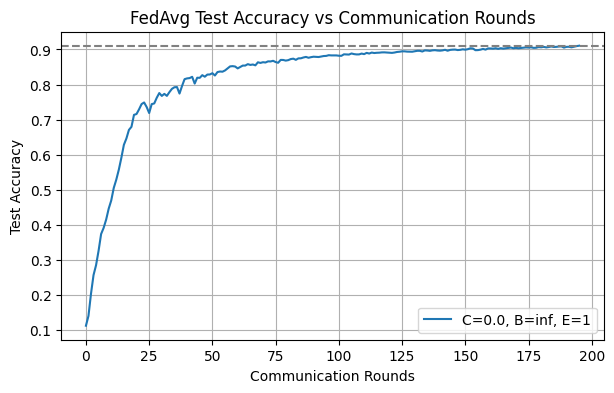


🔍 Running 2NN | IID | C=0.0, B=10

📊 Training with C=0.0, B=10, E=1, lr=0.05


Training Rounds:   0%|          | 8/2000 [00:15<1:05:16,  1.97s/round, Accuracy=0.915]


✅ Target accuracy 91.00% reached at round 9
🕒 Total time: 15.73 seconds


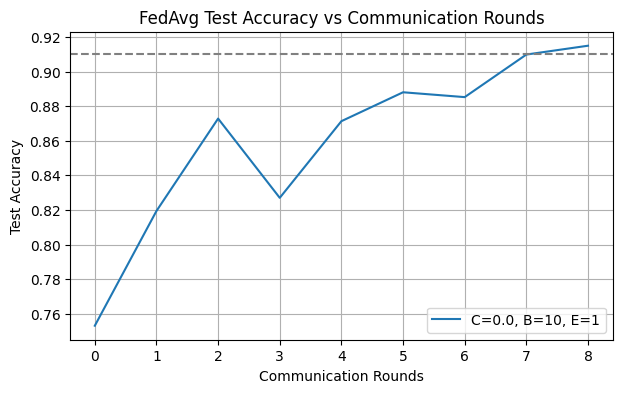


🔍 Running 2NN | IID | C=0.1, B=inf

📊 Training with C=0.1, B=inf, E=1, lr=0.05


Training Rounds:  10%|█         | 209/2000 [08:48<1:15:30,  2.53s/round, Accuracy=0.91] 


✅ Target accuracy 91.00% reached at round 210
🕒 Total time: 528.73 seconds


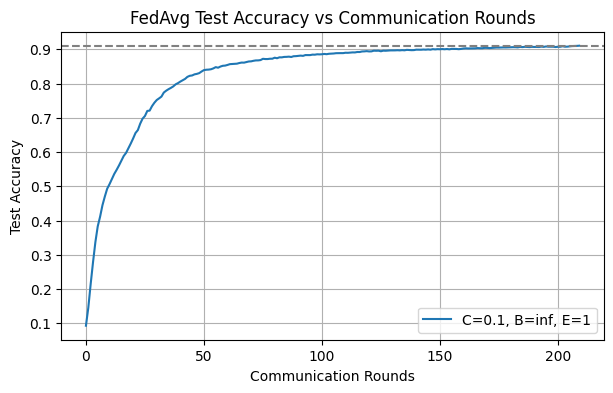


🔍 Running 2NN | IID | C=0.1, B=10

📊 Training with C=0.1, B=10, E=1, lr=0.05


Training Rounds:   0%|          | 4/2000 [00:16<2:17:11,  4.12s/round, Accuracy=0.915]


✅ Target accuracy 91.00% reached at round 5
🕒 Total time: 16.50 seconds


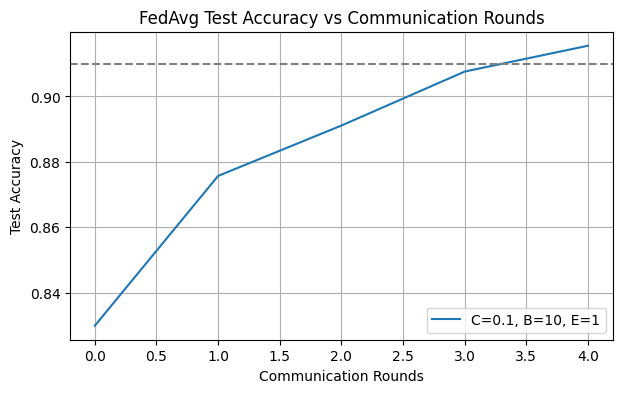


🔍 Running 2NN | IID | C=0.2, B=inf

📊 Training with C=0.2, B=inf, E=1, lr=0.05


Training Rounds:  11%|█         | 223/2000 [13:01<1:43:51,  3.51s/round, Accuracy=0.91] 


✅ Target accuracy 91.00% reached at round 224
🕒 Total time: 781.95 seconds


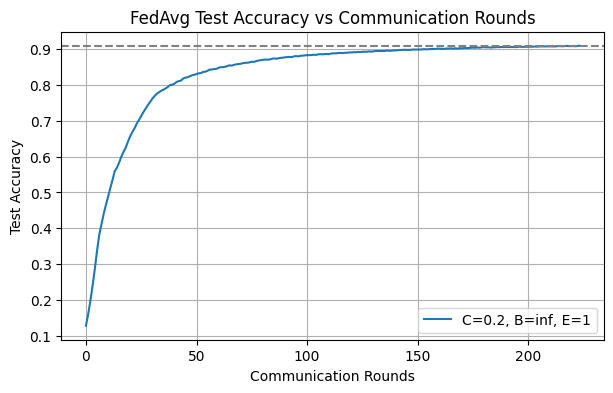


🔍 Running 2NN | IID | C=0.2, B=10

📊 Training with C=0.2, B=10, E=1, lr=0.05


Training Rounds:   0%|          | 4/2000 [00:24<3:27:04,  6.22s/round, Accuracy=0.914]


✅ Target accuracy 91.00% reached at round 5
🕒 Total time: 24.90 seconds


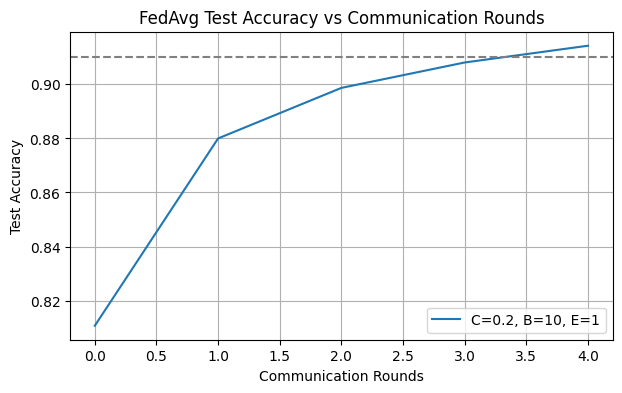


🔍 Running 2NN | IID | C=0.5, B=inf

📊 Training with C=0.5, B=inf, E=1, lr=0.05


Training Rounds:  11%|█         | 217/2000 [22:45<3:07:03,  6.29s/round, Accuracy=0.91] 


✅ Target accuracy 91.00% reached at round 218
🕒 Total time: 1365.97 seconds


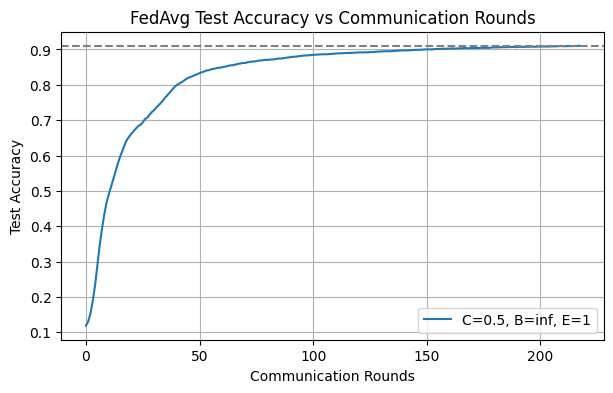


🔍 Running 2NN | IID | C=0.5, B=10

📊 Training with C=0.5, B=10, E=1, lr=0.05


Training Rounds:   0%|          | 3/2000 [00:40<7:28:25, 13.47s/round, Accuracy=0.911]


✅ Target accuracy 91.00% reached at round 4
🕒 Total time: 40.42 seconds


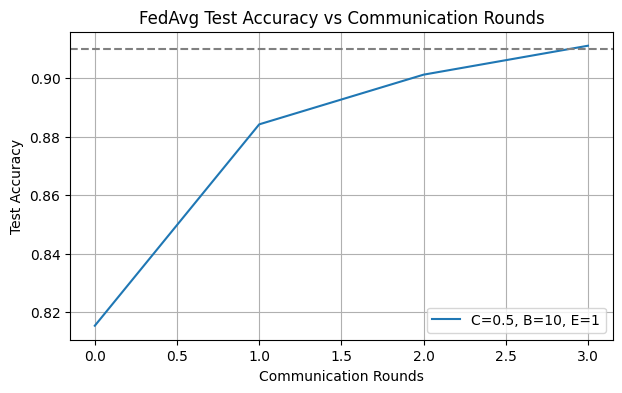


🔍 Running 2NN | IID | C=1.0, B=inf

📊 Training with C=1.0, B=inf, E=1, lr=0.05


Training Rounds:  11%|█         | 218/2000 [40:24<5:30:18, 11.12s/round, Accuracy=0.91] 


✅ Target accuracy 91.00% reached at round 219
🕒 Total time: 2424.51 seconds


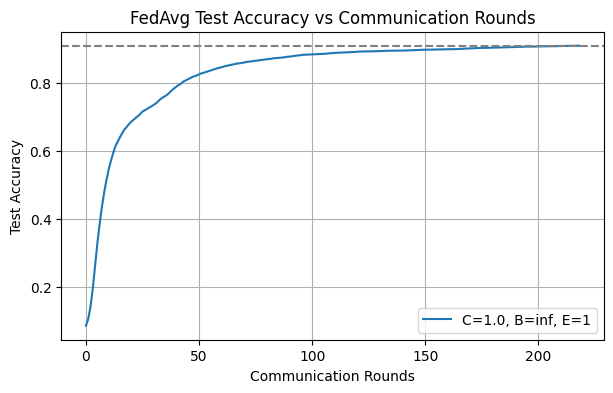


🔍 Running 2NN | IID | C=1.0, B=10

📊 Training with C=1.0, B=10, E=1, lr=0.05


Training Rounds:   0%|          | 3/2000 [01:16<14:07:47, 25.47s/round, Accuracy=0.911]


✅ Target accuracy 91.00% reached at round 4
🕒 Total time: 76.42 seconds


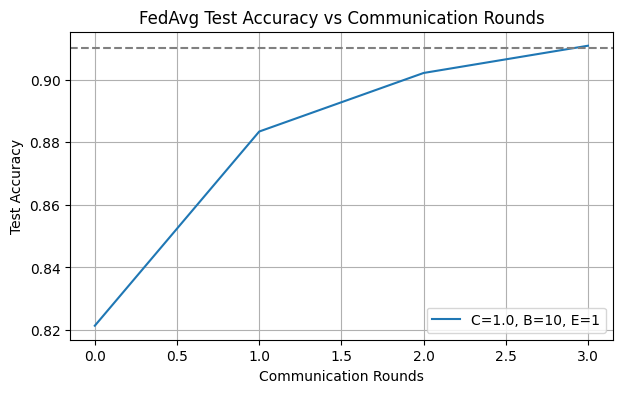

In [12]:
# 2NN Experiments
iid_2nn_results = run_mnist_experiments(
    MNIST_2NN, "2NN", E=1, target_acc=0.91, client_dict=iid_clients, label="IID", lr=0.05)





🔍 Running 2NN | Non-IID | C=0.0, B=inf

📊 Training with C=0.0, B=inf, E=1, lr=0.05


Training Rounds:  15%|█▌        | 302/2000 [08:14<46:22,  1.64s/round, Accuracy=0.91] 


✅ Target accuracy 91.00% reached at round 303
🕒 Total time: 494.91 seconds


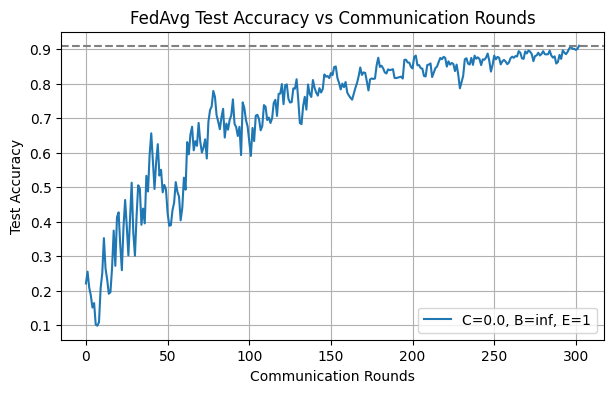


🔍 Running 2NN | Non-IID | C=0.0, B=10

📊 Training with C=0.0, B=10, E=1, lr=0.05


Training Rounds:  17%|█▋        | 331/2000 [09:29<47:50,  1.72s/round, Accuracy=0.91] 


✅ Target accuracy 91.00% reached at round 332
🕒 Total time: 569.31 seconds


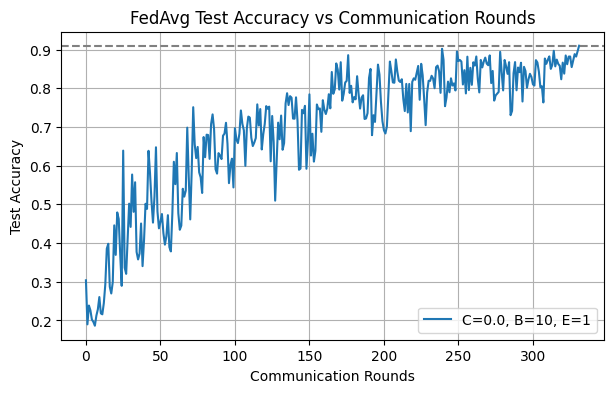


🔍 Running 2NN | Non-IID | C=0.1, B=inf

📊 Training with C=0.1, B=inf, E=1, lr=0.05


Training Rounds:  10%|█         | 210/2000 [08:35<1:13:12,  2.45s/round, Accuracy=0.912]


✅ Target accuracy 91.00% reached at round 211
🕒 Total time: 515.37 seconds


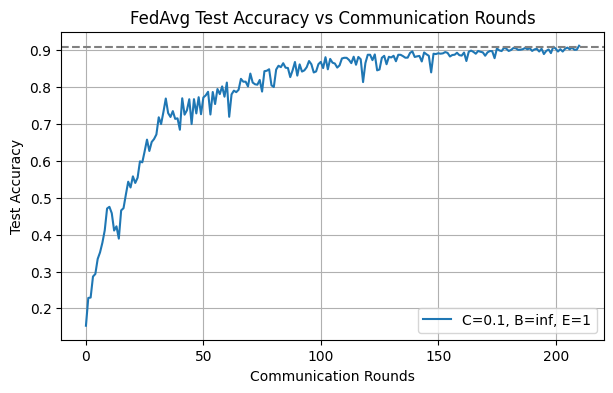


🔍 Running 2NN | Non-IID | C=0.1, B=10

📊 Training with C=0.1, B=10, E=1, lr=0.05


Training Rounds:   2%|▏         | 33/2000 [01:48<1:47:52,  3.29s/round, Accuracy=0.913]


✅ Target accuracy 91.00% reached at round 34
🕒 Total time: 108.60 seconds


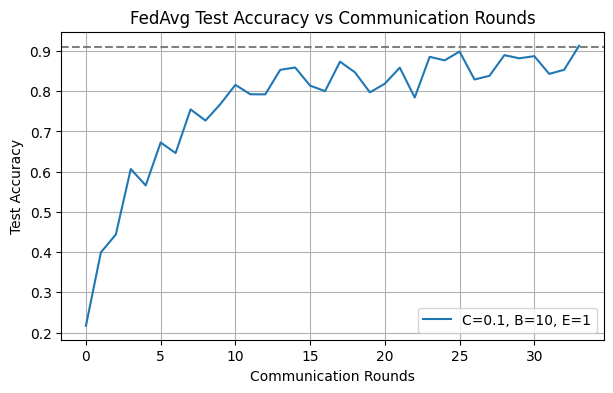


🔍 Running 2NN | Non-IID | C=0.2, B=inf

📊 Training with C=0.2, B=inf, E=1, lr=0.05


Training Rounds:  11%|█         | 212/2000 [12:12<1:43:00,  3.46s/round, Accuracy=0.91] 


✅ Target accuracy 91.00% reached at round 213
🕒 Total time: 732.76 seconds


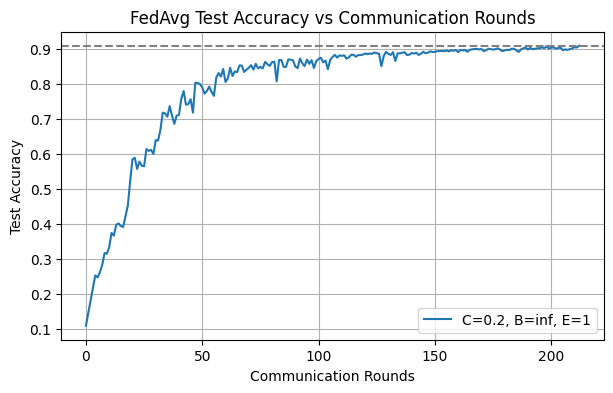


🔍 Running 2NN | Non-IID | C=0.2, B=10

📊 Training with C=0.2, B=10, E=1, lr=0.05


Training Rounds:   1%|          | 23/2000 [02:01<2:53:23,  5.26s/round, Accuracy=0.911]


✅ Target accuracy 91.00% reached at round 24
🕒 Total time: 121.03 seconds


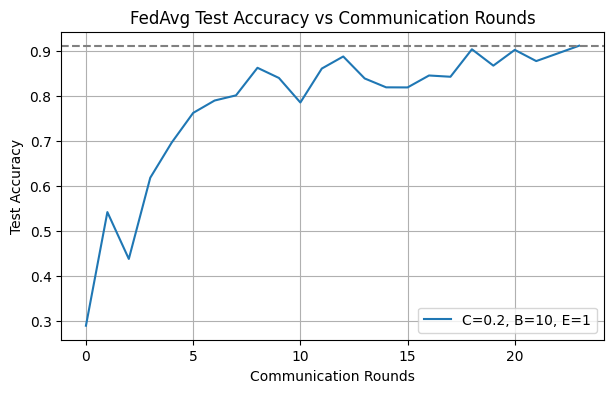


🔍 Running 2NN | Non-IID | C=0.5, B=inf

📊 Training with C=0.5, B=inf, E=1, lr=0.05


Training Rounds:  10%|█         | 201/2000 [21:22<3:11:22,  6.38s/round, Accuracy=0.91] 


✅ Target accuracy 91.00% reached at round 202
🕒 Total time: 1282.92 seconds


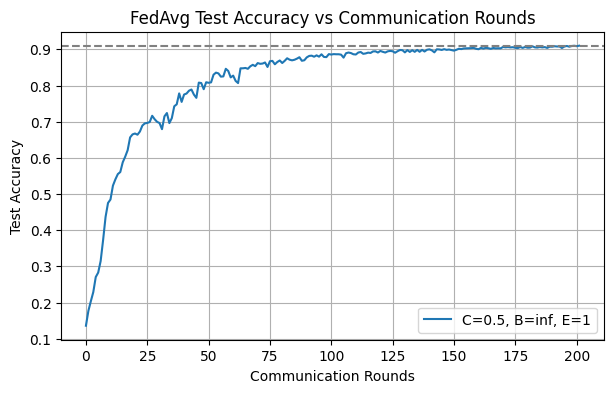


🔍 Running 2NN | Non-IID | C=0.5, B=10

📊 Training with C=0.5, B=10, E=1, lr=0.05


Training Rounds:   1%|          | 22/2000 [03:59<5:58:16, 10.87s/round, Accuracy=0.913]


✅ Target accuracy 91.00% reached at round 23
🕒 Total time: 239.10 seconds


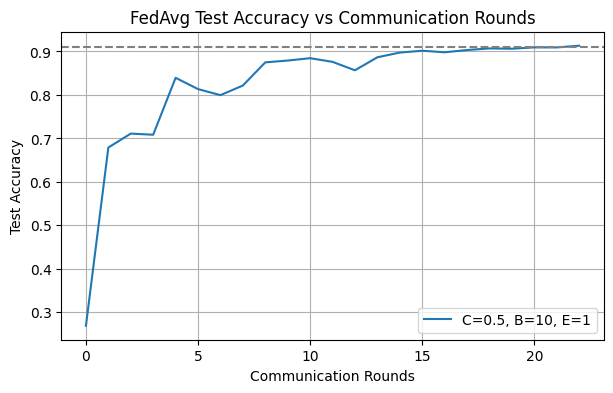


🔍 Running 2NN | Non-IID | C=1.0, B=inf

📊 Training with C=1.0, B=inf, E=1, lr=0.05


Training Rounds:  10%|█         | 204/2000 [38:24<5:38:12, 11.30s/round, Accuracy=0.91] 


✅ Target accuracy 91.00% reached at round 205
🕒 Total time: 2304.90 seconds


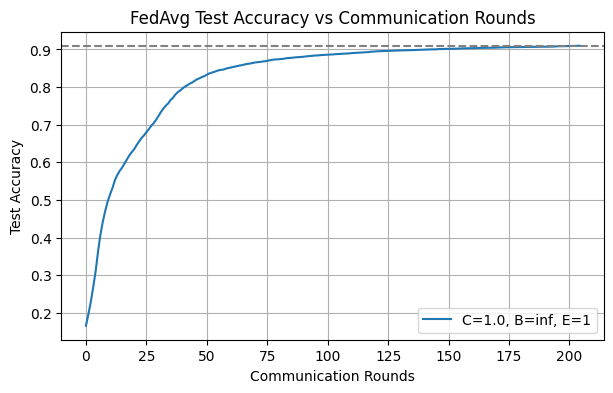


🔍 Running 2NN | Non-IID | C=1.0, B=10

📊 Training with C=1.0, B=10, E=1, lr=0.05


Training Rounds:   1%|          | 19/2000 [06:17<10:55:17, 19.85s/round, Accuracy=0.911]


✅ Target accuracy 91.00% reached at round 20
🕒 Total time: 377.10 seconds


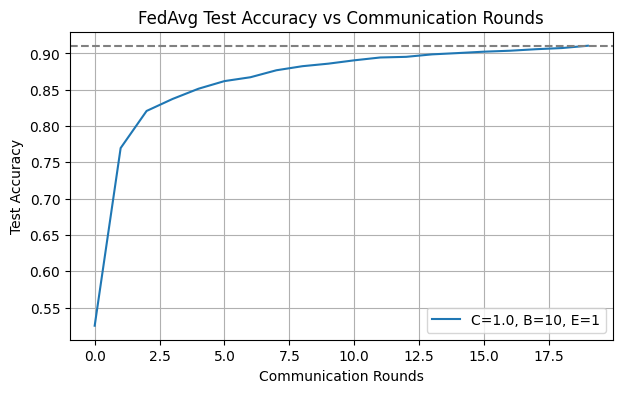

In [13]:
noniid_2nn_results = run_mnist_experiments(
    MNIST_2NN, "2NN", E=1, target_acc=0.91, client_dict=noniid_clients, label="Non-IID", lr=0.05)



🔍 Running CNN | IID | C=0.0, B=inf

📊 Training with C=0.0, B=inf, E=5, lr=0.01


Training Rounds:   4%|▎         | 72/2000 [02:47<1:14:33,  2.32s/round, Accuracy=0.921]


✅ Target accuracy 92.00% reached at round 73
🕒 Total time: 167.08 seconds


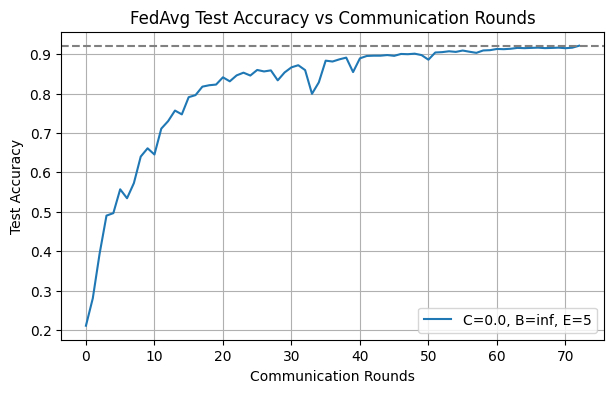


🔍 Running CNN | IID | C=0.0, B=10

📊 Training with C=0.0, B=10, E=5, lr=0.01


Training Rounds:   0%|          | 2/2000 [00:08<2:23:36,  4.31s/round, Accuracy=0.942]


✅ Target accuracy 92.00% reached at round 3
🕒 Total time: 8.63 seconds


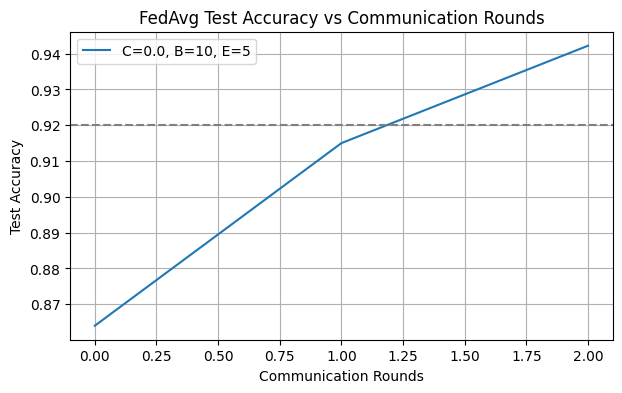


🔍 Running CNN | IID | C=0.1, B=inf

📊 Training with C=0.1, B=inf, E=5, lr=0.01


Training Rounds:   1%|          | 15/2000 [01:40<3:36:30,  6.54s/round, Accuracy=0.759]

In [ ]:

# CNN Experiments
iid_cnn_results = run_mnist_experiments(
    MNIST_CNN, "CNN", E=5, target_acc=0.92, client_dict=iid_clients, label="IID", lr=0.01)



In [ ]:
noniid_cnn_results = run_mnist_experiments(
    MNIST_CNN, "CNN", E=5, target_acc=0.92, client_dict=noniid_clients, label="Non-IID", lr=0.01)

In [ ]:
def plot_results(results_dict, title):
    plt.figure(figsize=(12, 6))
    for (C, B), (curve, _) in results_dict.items():
        label = f"C={C}, B={'∞' if B == 'inf' else B}"
        plt.plot(curve, label=label)
    plt.title(title)
    plt.xlabel("Communication Rounds")
    plt.ylabel("Test Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
plot_results(iid_2nn_results, "2NN - IID Partition")
plot_results(noniid_2nn_results, "2NN - Non-IID Partition")
plot_results(iid_cnn_results, "CNN - IID Partition")
plot_results(noniid_cnn_results, "CNN - Non-IID Partition")
